In [1]:
# ! pip install pyrip --upgrade
# ! conda install -q gdal=2.3.3

In [2]:
%matplotlib inline
import os

from pyrip.cog import query, query_radius, query_polygon, check_info
from pyrip.plot import plot

In [3]:
access_key_id = 'xxx'
secret_access_key = 'xxx'
endpoint_url = 'xxx'
endpoint = endpoint_url.replace('https://', '')

In [4]:
bucket = 'modis'
prefix = 'processed_images'

## Query Data

### Query Bounding Box

generate a geotiff for the given bounding box (min_lon, min_lat, max_lon, max_lat)

In [5]:
product = 'MOD13Q1.006'
layer = 'MOD13Q1_250m_16_days_NDVI'
date = '20200609'
bbox = (-74.4, 40.6, -73.6, 41.4)
result_tif = 'result.tif'


vrt_file = '/vsis3/{}/{}/product={}/layer={}/date={}/index.vrt'.format(bucket, prefix, product, layer, date)
query(vrt_file, bbox, result_tif, access_key_id=access_key_id, secret_access_key=secret_access_key, endpoint=endpoint)

'result.tif'

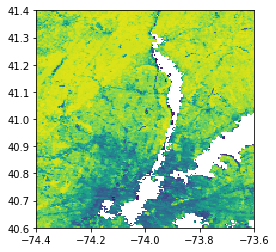

In [6]:
plot(result_tif)

### Query Radius

Generate a geotiff for the given point and radius. This will return a geotiff whose bounds are the minimal bounding box that covers the point-with-radius circle.

In this example, we extract the area that are within 30k meters from center NYC, i.e. a geotiff for Greater New York City area.

In [7]:
product = 'MOD13Q1.006'
layer = 'MOD13Q1_250m_16_days_EVI'
date = '20100101'
lat = 40.726810
lon = -73.994000
radius = 30000
result_tif = 'result.tif'


vrt_file = '/vsis3/{}/{}/product={}/layer={}/date={}/index.vrt'.format(bucket, prefix, product, layer, date)
query_radius(vrt_file, lat, lon, radius, result_tif, access_key_id=access_key_id, secret_access_key=secret_access_key, endpoint=endpoint)

'result.tif'

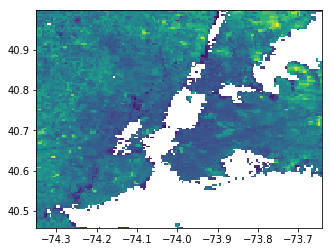

In [8]:
plot(result_tif)

### Query Polygon


Generate a geotiff for the given polygon. This will return a geotiff whose bounds are the minimal bounding box that covers the given polygon.


In this example, we have Long Island boundary polygon data in wkt format and want to extract the geotiff that perfectly covers that area 

In [9]:
product = 'MOD13Q1.006'
layer = 'MOD13Q1_250m_16_days_EVI'
date = '20190930'
poly_wkt = 'POLYGON((-73.90127285056394 40.86763288780581,-72.21487148337644 41.211521604167295,-71.72048671775144 41.062585707931504,-73.41787441306394 40.5553460045891,-74.10451992087644 40.546998310966146,-73.90127285056394 40.86763288780581))'
result_tif = 'result.tif'


vrt_file = '/vsis3/{}/{}/product={}/layer={}/date={}/index.vrt'.format(bucket, prefix, product, layer, date)
query_polygon(vrt_file, poly_wkt, result_tif, access_key_id=access_key_id, secret_access_key=secret_access_key, endpoint=endpoint)

'result.tif'

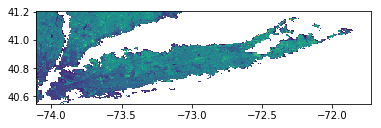

In [10]:
plot(result_tif)

## Parallel Query

You can query multiple images in parallel, with multi-nodes or multiprocessing on a single node.

Here is an exmaple of using multiprocessing pool to pull multiple images in parallel on a single node.

In [11]:
import pandas as pd
from multiprocessing import Pool

In [12]:
dates = pd.date_range('20200101', '20200331', freq='16D').strftime('%Y%m%d').tolist()

In [13]:
def f(date):
    result_tif = '{}_{}.tif'.format(layer, date)
    vrt_file = '/vsis3/{}/{}/product={}/layer={}/date={}/index.vrt'.format(bucket, prefix, product, layer, date)
    query(vrt_file, bbox, result_tif, access_key_id=access_key_id, secret_access_key=secret_access_key, endpoint=endpoint)
    return result_tif

In [14]:
with Pool() as p:
    tif_files = p.map(f, dates)

In [15]:
tif_files

['MOD13Q1_250m_16_days_EVI_20200101.tif',
 'MOD13Q1_250m_16_days_EVI_20200117.tif',
 'MOD13Q1_250m_16_days_EVI_20200202.tif',
 'MOD13Q1_250m_16_days_EVI_20200218.tif',
 'MOD13Q1_250m_16_days_EVI_20200305.tif',
 'MOD13Q1_250m_16_days_EVI_20200321.tif']

## Use cases

Being able to efficiently retrieve image from any layer, at any timestamp and in any region can be helpful in many ways. For example, you can quickly visualize satellite images for your area of interest to get a rough idea of how it looks like before starting your modeling. Another useful use case is to prepare data for deep learning models - you can leverage this demo to pull a time series of images for your area of interest, then use a sliding window to get sub-images for sub-regions. 

Following is one example output of leveraging this demo + deep learning to identify "anomalies" from satellite time series, which happens to be the 2018 Woolsey Fire that happened in California.

In [16]:
import tempfile

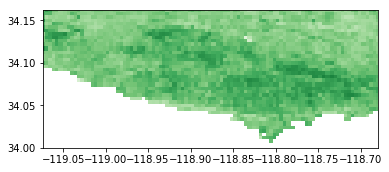

In [17]:
product = 'MOD13Q1.006'
layer = 'MOD13Q1_250m_16_days_NDVI'
date = '20181101'
bbox = (-119.072727, 34.0, -118.678968, 34.161326)
vrt_file = '/vsis3/{}/{}/product={}/layer={}/date={}/index.vrt'.format(bucket, prefix, product, layer, date)
with tempfile.NamedTemporaryFile(suffix='.tif') as tmp:
    query(vrt_file, bbox, tmp.name, access_key_id=access_key_id, secret_access_key=secret_access_key, endpoint=endpoint)
    plot(tmp.name, vmin=-2000, vmax=10000, cmap='Greens')

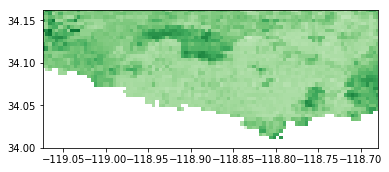

In [18]:
layer = 'MOD13Q1_250m_16_days_NDVI'
date = '20181117'
bbox = (-119.072727, 34.0, -118.678968, 34.161326)
vrt_file = '/vsis3/{}/{}/product={}/layer={}/date={}/index.vrt'.format(bucket, prefix, product, layer, date)
with tempfile.NamedTemporaryFile(suffix='.tif') as tmp:
    query(vrt_file, bbox, tmp.name, access_key_id=access_key_id, secret_access_key=secret_access_key, endpoint=endpoint)
    plot(tmp.name, vmin=-2000, vmax=10000, cmap='Greens')